In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [2]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [2]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [3]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [4]:
### our data are located within a publicly available folder on sciencedata.dk
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_aristotelicum = sddk.read_file("c_aristotelicum_repl.json", "df", publicfolder)
c_hippocraticum = sddk.read_file("c_hippocraticum_repl.json", "df", publicfolder)

this file is located in a public folder
this file is located in a public folder


In [11]:
# replace title on the basis of manual coding
c_hip_metadata = PIA_overview.worksheet("c_hip_metadata").get_all_records()
c_hip_title_dict = {pair["doc_id"] : pair["title_latin"] for pair in c_hip_metadata}
c_hippocraticum["title"] = c_hippocraticum.apply(lambda row: c_hip_title_dict[row["doc_id"]], axis=1)

In [12]:
c_hippocraticum.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmatized_sentences,lemmata_wordcount,num_of_sents,lemmata_repl,lemmatized_sentences_repl
1025,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,ΠΕΡΙ ΑΡΧΑΙΗΣ ΙΗΤΡΙΚΗΣ ὁπόσοι μὲν ἐπεχείρησαν π...,tlg0627,tlg0627.tlg001,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,5537,"[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικῆ...","[[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικ...",2463,257,"[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικῆ...","[[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικ..."
1026,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",tlg0627,tlg0627.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,7502,"[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω,...","[[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω...",3393,461,"[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω,...","[[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω..."
1027,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,ΠΡΟΓΝΩΣΤΙΚΟΝ 1. τὸν ἰητρὸν δοκέει μοι ἄριστον ...,tlg0627,tlg0627.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,5243,"[προγνωστικον, ἰατρός, δοκέω, ἁμός, ἄριστον, π...","[[προγνωστικον], [ἰατρός, δοκέω, ἁμός, ἄριστον...",2489,303,"[προγνωστικον, ἰατρός, δοκέω, ἁμός, ἄριστον, π...","[[προγνωστικον], [ἰατρός, δοκέω, ἁμός, ἄριστον..."
1028,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ 1. οἱ ξυγγράψαντες τὰς Κνιδ...,tlg0627,tlg0627.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,6149,"[δίαιτα, ὄξος, ξυγγράψαντες, Κνίδιος, γνώμη, ὁ...","[[δίαιτα, ὄξος], [ξυγγράψαντες, Κνίδιος, γνώμη...",2983,370,"[δίαιτα, ὄξος, ξυγγράψαντες, Κνίδιος, γνώμη, ὁ...","[[δίαιτα, ὄξος], [ξυγγράψαντες, Κνίδιος, γνώμη..."
1029,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),"ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ ΝΟΘΑ. 1. καῦσος γίγνεται, ὁ...",tlg0627,tlg0627.tlg005,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,5260,"[δίαιτα, ὄξος, νόθος, καῦσος, γίγνομαι, ὁκόταν...","[[δίαιτα, ὄξος, νόθος], [καῦσος, γίγνομαι, ὁκό...",2910,351,"[δίαιτα, ὄξος, νόθος, καῦσος, γίγνομαι, ὁκόταν...","[[δίαιτα, ὄξος, νόθος], [καῦσος, γίγνομαι, ὁκό..."


In [13]:
# patterns used in the replacement
keyterm_patterns = [("^λ[υ|ύ]π.+", "λύπ*"), ("^[ἀ|ἄ]λγ.+", "ἄλγ*"), ("^[ὀ|ὠ]δ[ύ|υ]ν.", "ὀδύν*"), ("^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+", "πόνο*")]

In [14]:
# make overview columns of individual terms accross documents
for pattern_tuple in keyterm_patterns:
  term = pattern_tuple[1] # eg. "λύπ*"
  c_aristotelicum[term] =  c_aristotelicum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
  c_hippocraticum[term] =  c_hippocraticum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
c_aristotelicum["terms_sum"] = c_aristotelicum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]), axis=1)
c_hippocraticum["terms_sum"] = c_hippocraticum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]), axis=1)

In [15]:
c_aristotelicum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*     391
ἄλγ*      32
ὀδύν*      3
πόνο*    100
dtype: int64

In [16]:
c_hippocraticum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*      58
ἄλγ*     315
ὀδύν*    642
πόνο*    651
dtype: int64

In [18]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]:
  c_aristotelicum[term + "_weighted"] = c_aristotelicum.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
  c_hippocraticum[term + "_weighted"] = c_hippocraticum.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
c_aristotelicum["weighted_sum"] = c_aristotelicum.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)
c_hippocraticum["weighted_sum"] = c_hippocraticum.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)

In [19]:
# uncomment to export overview data to gsheet
set_with_dataframe(PIA_overview.add_worksheet("c_aristotelicum_20200820",1,1), c_aristotelicum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))
set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_20200820",1,1), c_hippocraticum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))

# Selected works

In [20]:
# in what follows, we mainly focus upon a subselection of works from the two corpora
# we believe that these subselected works coverepresent the most relevant texts dealing with the topic of pain

ar_sel = ["tlg0086.tlg003", "tlg0086.tlg009", "tlg0086.tlg010", "tlg0086.tlg012", "tlg0086.tlg014", "tlg0086.tlg020", "tlg0086.tlg021", "tlg0086.tlg025", "tlg0086.tlg035", "tlg0086.tlg038"]
hip_sel = ["tlg0627.tlg001", "tlg0627.tlg003", "tlg0627.tlg006", "tlg0627.tlg009", "tlg0627.tlg012", "tlg0627.tlg017", "tlg0627.tlg019", "tlg0627.tlg031", "tlg0627.tlg032", "tlg0627.tlg033"]


In [21]:
# use these to filter within our dataframe
c_aristotelicum_10 = c_aristotelicum[c_aristotelicum["doc_id"].isin(ar_sel)]
c_hippocraticum_10 = c_hippocraticum[c_hippocraticum["doc_id"].isin(hip_sel)]

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


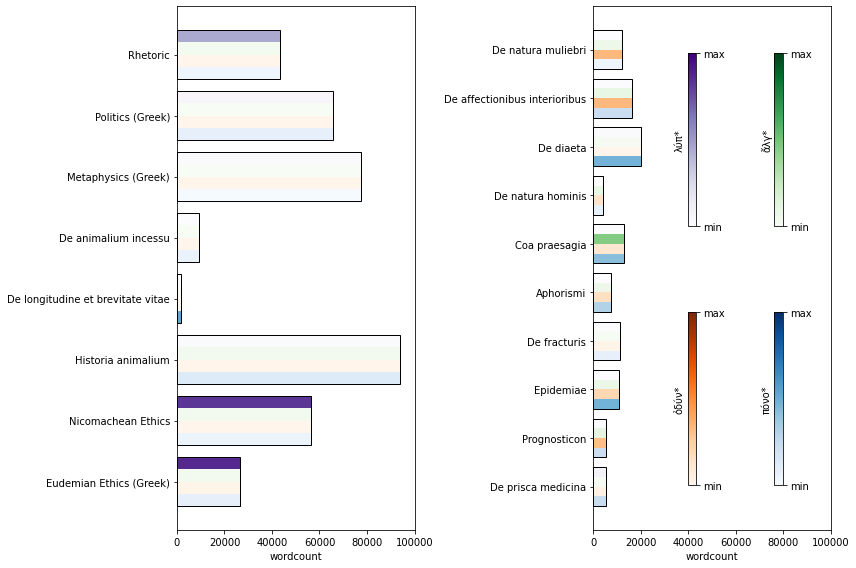

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# alternatively, choose 10 workds with maximal weighted sum of pain terms
#c_aristotelicum_10 = c_aristotelicum.sort_values("weighted_sum", ascending=False)[:10][::-1]
#c_hippocraticum_10 = c_hippocraticum.sort_values("weighted_sum", ascending=False)[:10][::-1]

# preproducing the figure object
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 8), tight_layout=True)

# CORPUS ARISTOTELICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]
wordcounts = c_aristotelicum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Blues")]:
  coloring = c_aristotelicum_10[keyterm + "_weighted"] / c_aristotelicum_10["weighted_sum"].max()
  ax1.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax1.barh(y, wordcounts, width * 4, color="none", edgecolor="black")
#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel("wordcount")
#ax1.set_ylabel("documents")
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
ax1.set_xlim(0, 100000)
# ax.legend()

# CORPUS HIPPOCRATICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_hippocraticum_10["title"].tolist()]
wordcounts = c_hippocraticum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Blues")]:
  coloring = c_hippocraticum_10[keyterm + "_weighted"] / c_hippocraticum_10["weighted_sum"].max()
  cmap = plt.get_cmap(colormap)
  ax2.barh(y + 0.3 - bar_location, wordcounts, width, color=cmap(coloring), label=keyterm)
  bar_location = bar_location + 0.2



ax2.barh(y, wordcounts, width * 4, color="none", edgecolor="black")


#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xlabel("wordcount")
#ax2.set_ylabel("documents")
ax2.set_yticks(y)
ax2.set_yticklabels(labels)
ax2.set_xlim(0, 100000)
# ax.legend()

cblocs =    [[0.8, 0.6, 0.01, 0.3],# [left, bottom, width, height]
             [0.9, 0.6, 0.01, 0.3],
             [0.8, 0.15, 0.01, 0.3],
             [0.9, 0.15, 0.01, 0.3]
]

for keyterm, colormap, location in [("λύπ*", "Purples", cblocs[0]), ("ἄλγ*", "Greens", cblocs[1]), ("ὀδύν*", "Oranges", cblocs[2]),	("πόνο*", "Blues", cblocs[3])]:
  cmap = plt.get_cmap(colormap)
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbaxes = fig.add_axes(location) # [left, bottom, width, height]
  cb = plt.colorbar(sm, cax=cbaxes) #shrink=0.2) #, ticks=np.arange(0,n))
  cb.set_ticks([0,1])
  cb.set_ticklabels(["min", "max"])
  cb.set_label(keyterm, labelpad=-50)
  #plt.show()


#fig.tight_layout()

plt.show()

In [23]:
# uncomment to export:
sddk.write_file("public_data/PIA/terms-colorbar.png", fig, conf)

A file with the same name ("terms-colorbar.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 


/srv/conda/envs/notebook/lib/python3.7/site-packages/sddk/__init__.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  python_object.savefig('temp.png', dpi=python_object.dpi)


Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/terms-colorbar.png"


# Pie charts (probably not used...)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


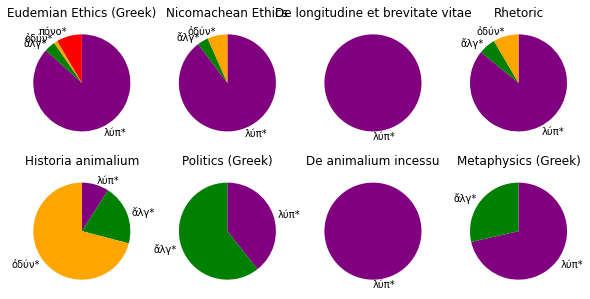

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


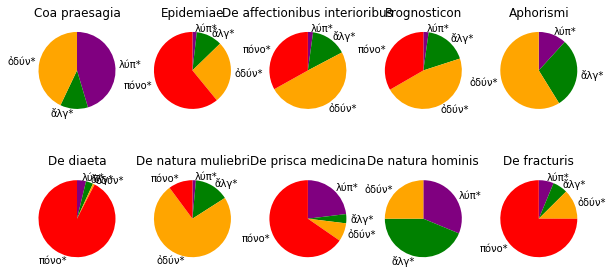

In [24]:
# PIE CHART (OF THE SAME DATA)

c_aristotelicum_10.sort_values("weighted_sum", ascending=False, inplace=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
titles = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]
terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]
#values = c_aristotelicum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()


fig, axs  = plt.subplots(2, 4, figsize=(10,5))

for ax, n, title in zip(axs.ravel(), range(8), titles):
  values = c_aristotelicum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
  sizes = [val / c_aristotelicum_10.iloc[n]["weighted_sum"] * 100 for val in  values if val > 0]
  #labels = [term_value[0] + "(" + str(np.round(term_value[1], 4)) + ")" for term_value in zip(terms, values)]
  labels = terms
  ax.pie(sizes, colors=["purple", "green", "orange", "red"], labels=labels[:len(sizes)], startangle=90, counterclock=False)
  ax.set_title(title, wrap=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


c_hippocraticum_10.sort_values("weighted_sum", ascending=False, inplace=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
titles = [title.partition(";")[0].partition(".")[0] for title in c_hippocraticum_10["title"].tolist()]
terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]
values = c_hippocraticum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
fig, axs  = plt.subplots(2, 5, figsize=(10,5))


for ax, n, title in zip(axs.ravel(), range(10), titles):
  values = c_hippocraticum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
  sizes = [val / c_hippocraticum_10.iloc[n]["weighted_sum"] * 100 for val in  values if val > 0]
  #labels = [term_value[0] + "(" + str(np.round(term_value[1], 4)) + ")" for term_value in zip(terms, values)]
  labels = terms
  ax.pie(sizes, colors=["purple", "green", "orange", "red"], labels=labels[:len(sizes)], startangle=90, counterclock=False)
  ax.set_title(title, wrap=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Combined barplot


In [25]:
category_colors = ["Purple", "Green", "Blue", "Red"]

In [26]:
def plot_ratios(corpus_df):
  data = {}
  for n in range(len(corpus_df)):
    label = corpus_df.iloc[n]["title"].partition(";")[0].partition(".")[0] + " (" + str(corpus_df.iloc[n]["wordcount"]) + " words)"
    counts = corpus_df.iloc[n][["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].tolist()
    values = corpus_df.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
    values = [0 if math.isnan(x) else x for x in values]
    ratios = [val / corpus_df.iloc[n]["weighted_sum"] * 100 for val in  values] # if val > 0]
    ratios = [0 if math.isnan(x) else x for x in ratios]
    data[label] = (counts, ratios)

  labels = list(data.keys())
  counts = np.array([el[0] for el in list(data.values())])
  ratios = np.array([el[1] for el in list(data.values())])
  ratios_cum = ratios.cumsum(axis=1)

  category_colors = ["Purple", "Green", "Blue", "Red"]

  terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]


  fig, ax = plt.subplots(figsize=(12, len(corpus_df)/4 + 1), tight_layout=True)
  ax.invert_yaxis()
  ax.xaxis.set_visible(False)

  ax.set_xlim(0, np.sum(ratios, axis=1).max())
  ax.set_ylim(-0.5, len(corpus_df) - 0.5)

  for i, (term, color) in enumerate(zip(terms, category_colors)):
          widths = ratios[:, i]
          texts = counts[:, i]
          starts = ratios_cum[:, i] - widths
          ax.barh(labels, widths, left=starts,
                  label=term, color=color)
          xcenters = starts + widths / 2
          for y, (x, c) in enumerate(zip(xcenters, texts)):
              if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
              else:
                ax.text(x, y, "", ha='center', va='center', color='white')
  ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
  return fig

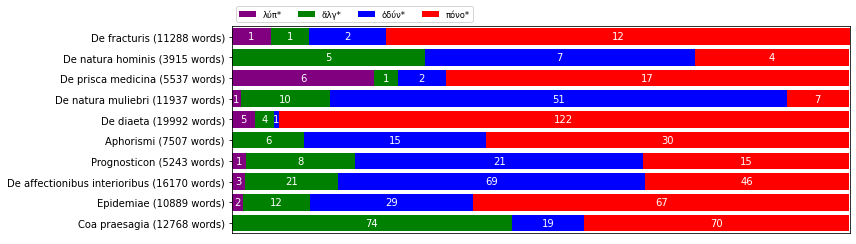

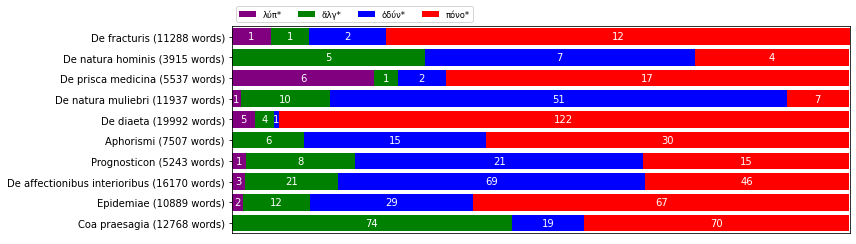

In [27]:
plot_ratios(c_hippocraticum_10)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


A file with the same name ("ratios_c_hippocraticum.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/ratios_c_hippocraticum.png"
A file with the same name ("ratios_c_hippocraticum_10.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/ratios_c_hippocraticum_10.png"


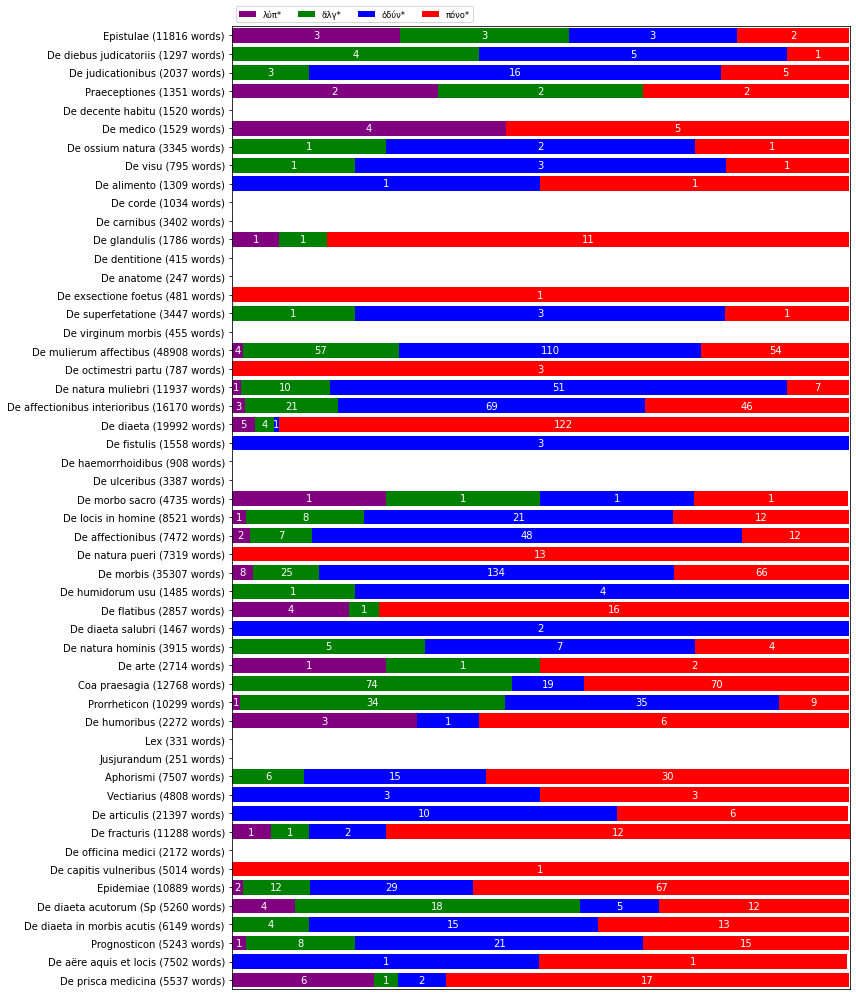

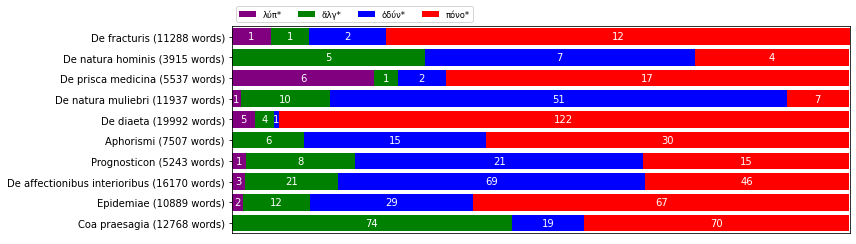

In [28]:
# uncomment to generate figures & export them to sciencedata
# sddk.write_file("public_data/PIA/ratios_c_aristotelicum.png", plot_ratios(c_aristotelicum), conf)
# sddk.write_file("public_data/PIA/ratios_c_aristotelicum_10.png", plot_ratios(c_aristotelicum_10), conf)
sddk.write_file("public_data/PIA/ratios_c_hippocraticum.png", plot_ratios(c_hippocraticum), conf)
sddk.write_file("public_data/PIA/ratios_c_hippocraticum_10.png", plot_ratios(c_hippocraticum_10), conf)

# Work types / document clustering

In [29]:
c_hip_metadata = PIA_overview.worksheet("c_hip_metadata").get_all_records()
c_hip_cat_dict = {pair["doc_id"] : pair["work_category"] for pair in c_hip_metadata}
print(c_hip_cat_dict)

{'tlg0627.tlg001': 'H', 'tlg0627.tlg002': 'C', 'tlg0627.tlg003': 'D', 'tlg0627.tlg004': 'D', 'tlg0627.tlg005': '', 'tlg0627.tlg006': 'B', 'tlg0627.tlg007': 'A', 'tlg0627.tlg008': '', 'tlg0627.tlg009': 'A', 'tlg0627.tlg010': 'A', 'tlg0627.tlg011': 'A', 'tlg0627.tlg012': 'E', 'tlg0627.tlg013': '', 'tlg0627.tlg014': '', 'tlg0627.tlg015': 'B', 'tlg0627.tlg016': '', 'tlg0627.tlg017': '', 'tlg0627.tlg018': '', 'tlg0627.tlg019': 'H', 'tlg0627.tlg020': '', 'tlg0627.tlg021': '', 'tlg0627.tlg022': '', 'tlg0627.tlg023': '', 'tlg0627.tlg024': '', 'tlg0627.tlg025': '', 'tlg0627.tlg026': '', 'tlg0627.tlg027': 'C', 'tlg0627.tlg028': '', 'tlg0627.tlg029': '', 'tlg0627.tlg030': '', 'tlg0627.tlg031': 'G', 'tlg0627.tlg032': 'F', 'tlg0627.tlg033': 'F', 'tlg0627.tlg035': '', 'tlg0627.tlg036': 'F', 'tlg0627.tlg037': 'F', 'tlg0627.tlg038': '', 'tlg0627.tlg039': '', 'tlg0627.tlg040': '', 'tlg0627.tlg041': '', 'tlg0627.tlg042': '', 'tlg0627.tlg043': 'G', 'tlg0627.tlg045': '', 'tlg0627.tlg046': '', 'tlg0627.tlg

In [30]:
c_hippocraticum["work_cat"] = c_hippocraticum.apply(lambda row: c_hip_cat_dict[row["doc_id"]], axis=1)
c_hippocraticum.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,...,ἄλγ*,ὀδύν*,πόνο*,terms_sum,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum,work_cat
1025,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,ΠΕΡΙ ΑΡΧΑΙΗΣ ΙΗΤΡΙΚΗΣ ὁπόσοι μὲν ἐπεχείρησαν π...,tlg0627,tlg0627.tlg001,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,1,2,17,26,0.001084,0.000181,0.000361,0.003070,0.004696,H
1026,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",tlg0627,tlg0627.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,0,1,1,2,0.000000,0.000000,0.000133,0.000133,0.000267,C
1027,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,ΠΡΟΓΝΩΣΤΙΚΟΝ 1. τὸν ἰητρὸν δοκέει μοι ἄριστον ...,tlg0627,tlg0627.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,8,21,15,45,0.000191,0.001526,0.004005,0.002861,0.008583,D
1028,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ 1. οἱ ξυγγράψαντες τὰς Κνιδ...,tlg0627,tlg0627.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,4,15,13,32,0.000000,0.000651,0.002439,0.002114,0.005204,D
1029,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),"ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ ΝΟΘΑ. 1. καῦσος γίγνεται, ὁ...",tlg0627,tlg0627.tlg005,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,18,5,12,39,0.000760,0.003422,0.000951,0.002281,0.007414,


In [34]:
cats = sorted(c_hippocraticum["work_cat"].unique().tolist())
cats

['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [35]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'string', 'author_id', 'doc_id',
       'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience',
       'wordcount', 'lemmata', 'lemmatized_sentences', 'lemmata_wordcount',
       'num_of_sents', 'lemmata_repl', 'lemmatized_sentences_repl', 'λύπ*',
       'ἄλγ*', 'ὀδύν*', 'πόνο*', 'terms_sum', 'λύπ*_weighted', 'ἄλγ*_weighted',
       'ὀδύν*_weighted', 'πόνο*_weighted', 'weighted_sum', 'work_cat'],
      dtype='object')

In [34]:
c_hippocraticum_by_cat = c_hippocraticum.groupby("work_cat").sum().drop(['date_avr', 'date_manual', "λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted", 'weighted_sum'], axis=1)
c_hippocraticum_by_cat.reset_index(inplace=True)

In [35]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]:
    c_hippocraticum_by_cat[term + "_weighted"] = c_hippocraticum_by_cat.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
c_hippocraticum_by_cat["weighted_sum"] = c_hippocraticum_by_cat.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)

In [36]:
c_hippocraticum_by_cat

,work_cat,wordcount,lemmata_wordcount,num_of_sents,λύπ*,ἄλγ*,ὀδύν*,πόνο*,terms_sum,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum
0,,135921,69446,9014,29,183,304,244,760,0.000213,0.001346,0.002237,0.001795,0.005591
1,A,42507,19832,2613,1,1,15,22,39,0.000024,0.000024,0.000353,0.000518,0.000917
2,B,13161,7875,1362,5,12,30,73,120,0.000380,0.000912,0.002279,0.005547,0.009118
3,C,12237,5537,696,1,1,2,2,6,0.000082,0.000082,0.000163,0.000163,0.000490
4,D,11392,5472,673,1,12,36,28,77,0.000088,0.001053,0.003160,0.002458,0.006759
5,E,8858,4735,694,2,8,15,32,57,0.000226,0.000903,0.001693,0.003613,0.006435
6,F,77470,44325,5282,8,88,230,107,433,0.000103,0.001136,0.002969,0.001381,0.005589
7,G,23394,11537,1627,5,4,1,122,132,0.000214,0.000171,0.000043,0.005215,0.005642
8,H,9452,4193,443,6,6,9,21,42,0.000635,0.000635,0.000952,0.002222,0.004444


In [37]:
#set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_by_cat", 1, 1), c_hippocraticum_by_cat)

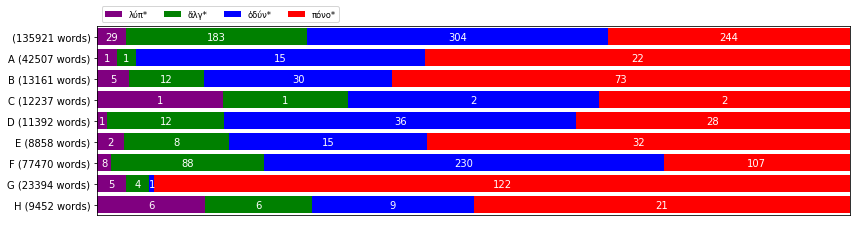

In [38]:
data = []
labels = []
counts = []
ratios = []

# reverse order:
c_hippocraticum_by_cat = c_hippocraticum_by_cat[::-1]

for n in range(len(c_hippocraticum_by_cat[::-1])):
    label = str(c_hippocraticum_by_cat.iloc[n]["work_cat"]) + " (" + str(c_hippocraticum_by_cat.iloc[n]["wordcount"]) + " words)"
    labels.append(label)
    cat_counts = c_hippocraticum_by_cat.iloc[n][["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].tolist()
    counts.append(cat_counts)
    cat_ratios = [val / c_hippocraticum_by_cat.iloc[n]["terms_sum"] * 100 for val in  cat_counts] # if val > 0]
    cat_ratios = [0 if math.isnan(x) else x for x in cat_ratios]
    ratios.append(cat_ratios)

counts = np.array(counts)
ratios = np.array(ratios)
ratios_cum = ratios.cumsum(axis=1)

category_colors = ["Purple", "Green", "Blue", "Red"]

terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]


fig, ax = plt.subplots(figsize=(12, (len(c_hippocraticum_by_cat) / 4) + 1), tight_layout=True)
ax.invert_yaxis()
ax.xaxis.set_visible(False)

ax.set_xlim(0, np.sum(ratios, axis=1).max())
ax.set_ylim(-0.5, len(c_hippocraticum_by_cat) - 0.5)

for i, (term, color) in enumerate(zip(terms, category_colors)):
          widths = ratios[:, i]
          texts = counts[:, i]
          starts = ratios_cum[:, i] - widths
          ax.barh(labels, widths, left=starts,
                  label=term, color=color)
          xcenters = starts + widths / 2
          for y, (x, c) in enumerate(zip(xcenters, texts)):
              if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
              else:
                ax.text(x, y, "", ha='center', va='center', color='white')
ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')

In [49]:
sddk.write_file("public_data/PIA/c_hip_ratios_by_cat.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_ratios_by_cat.png"


# Document distances

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'string', 'author_id', 'doc_id',
       'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience',
       'wordcount', 'lemmata', 'lemmatized_sentences', 'lemmata_wordcount',
       'num_of_sents', 'lemmata_repl', 'lemmatized_sentences_repl', 'λύπ*',
       'ἄλγ*', 'ὀδύν*', 'πόνο*', 'terms_sum', 'λύπ*_weighted', 'ἄλγ*_weighted',
       'ὀδύν*_weighted', 'πόνο*_weighted', 'weighted_sum', 'work_cat'],
      dtype='object')

In [41]:
# as an input for vectorization, we need the documents in a form of strings
# we need two lists:
# (1) list of strings
# (2) list of work names
strings = [" ".join(lemmata) for lemmata in c_hippocraticum["lemmata"].tolist()]
titles = c_hippocraticum["title"].tolist()


In [42]:
def make_vec_df(list_of_string_docs, doc_names):
  vec = CountVectorizer()
  X = vec.fit_transform(list_of_string_docs)
  vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(), index=doc_names)
  cosine_sim = cosine_similarity(X.toarray()) 
  cosine_sim_df = pd.DataFrame(np.round(cosine_sim, 5), columns=doc_names, index=doc_names)
  cosine_dist = 1 - cosine_similarity(X.toarray())
  cosine_dist_df = pd.DataFrame(np.round(cosine_dist, 5), columns=doc_names, index=doc_names)
  return [vectorization_df, cosine_sim_df, cosine_dist_df, doc_names]

In [43]:
c_hip_vec = make_vec_df(strings, titles)

In [64]:
c_hip_vec[2]

,On Ancient Medicine; Hippocrates Collected Works I,De aere aquis et locis ; Hippocrates Collected Works I,The Book of Prognostics ; Oeuvres Completes D'Hippocrate.,On Regimen in Acute Diseases ; Oeuvres Completes D'Hippocrate.,Acut. sp. ; Oeuvres Completes D'Hippocrate.,Of the Epidemics ; Hippocrates Collected Works I,On Injuries of the Head; Oeuvres Completes D'Hippocrate.,De officina medici ; Oeuvres Completes D'Hippocrate.,On Fractures ; Oeuvres Completes D'Hippocrate.,On the Articulations ; Oeuvres Completes D'Hippocrate.,...,De corde; Oeuvres complètes d'Hippocrate,De alimento ; Hippocrates Collected Works I,De visu; Oeuvres complètes d'Hippocrate,De natura ossium; Oeuvres complètes d'Hippocrate,De medico; Oeuvres complètes d'Hippocrate,De habitu decenti; Oeuvres complètes d'Hippocrate,Precepts ; Hippocrates Collected Works I,De crisibus; Oeuvres complètes d'Hippocrate,De diebus criticis; Oeuvres complètes d'Hippocrate,"Epistulae, Decretum, Orationes; Oeuvres complètes d'Hippocrate"
On Ancient Medicine; Hippocrates Collected Works I,0.00000,0.42615,0.51021,0.48698,0.62581,0.58608,0.74151,0.71895,0.61764,0.52113,...,0.61965,0.66254,0.70615,0.80891,0.61788,0.59002,0.61646,0.60973,0.57877,0.46948
De aere aquis et locis ; Hippocrates Collected Works I,0.42615,0.00000,0.50584,0.51305,0.51702,0.63764,0.71711,0.71667,0.63551,0.55593,...,0.64716,0.74548,0.66905,0.77473,0.66514,0.72991,0.69260,0.59645,0.52836,0.53167
The Book of Prognostics ; Oeuvres Completes D'Hippocrate.,0.51021,0.50584,-0.00000,0.39590,0.40882,0.59425,0.65400,0.73515,0.46995,0.42105,...,0.73536,0.76434,0.58395,0.79520,0.65194,0.69081,0.64637,0.31696,0.42868,0.60848
On Regimen in Acute Diseases ; Oeuvres Completes D'Hippocrate.,0.48698,0.51305,0.39590,-0.00000,0.41625,0.62396,0.69765,0.65535,0.46507,0.43833,...,0.69470,0.72051,0.63549,0.76964,0.59709,0.60787,0.55349,0.52332,0.51614,0.54848
Acut. sp. ; Oeuvres Completes D'Hippocrate.,0.62581,0.51702,0.40882,0.41625,-0.00000,0.65476,0.68559,0.75519,0.55472,0.50525,...,0.73247,0.81100,0.56317,0.76951,0.75800,0.82220,0.69138,0.42504,0.42448,0.74153
Of the Epidemics ; Hippocrates Collected Works I,0.58608,0.63764,0.59425,0.62396,0.65476,0.00000,0.84415,0.77688,0.74182,0.71657,...,0.80785,0.77472,0.79094,0.83763,0.72575,0.68789,0.75466,0.51534,0.67762,0.66256
On Injuries of the Head; Oeuvres Completes D'Hippocrate.,0.74151,0.71711,0.65400,0.69765,0.68559,0.84415,0.00000,0.76548,0.31814,0.43709,...,0.85257,0.81204,0.60938,0.78989,0.75550,0.83993,0.81684,0.73709,0.70301,0.79762
De officina medici ; Oeuvres Completes D'Hippocrate.,0.71895,0.71667,0.73515,0.65535,0.75519,0.77688,0.76548,0.00000,0.58531,0.55397,...,0.82582,0.75889,0.77080,0.72566,0.70205,0.81573,0.79027,0.77469,0.76787,0.74263
On Fractures ; Oeuvres Completes D'Hippocrate.,0.61764,0.63551,0.46995,0.46507,0.55472,0.74182,0.31814,0.58531,0.00000,0.18546,...,0.78396,0.75786,0.59036,0.71677,0.60267,0.65121,0.68598,0.65914,0.60940,0.66453
On the Articulations ; Oeuvres Completes D'Hippocrate.,0.52113,0.55593,0.42105,0.43833,0.50525,0.71657,0.43709,0.55397,0.18546,-0.00000,...,0.75112,0.74905,0.55837,0.66481,0.58605,0.65015,0.65291,0.59951,0.52832,0.60880


In [75]:
# to get colors based on work category
# for each document category generate a random color
color_pairs = {}
for cat in c_hippocraticum["work_cat"].unique().tolist():
    color_pairs[cat] = np.random.rand(3,)
color_pairs

{'H': array([0.63411483, 0.85898089, 0.24055473]),
 'C': array([0.03004824, 0.64965834, 0.93265906]),
 'D': array([0.74191045, 0.6854183 , 0.76811673]),
 '': array([0.84651822, 0.3476953 , 0.45637886]),
 'B': array([0.94936396, 0.64586446, 0.60087416]),
 'A': array([0.8440161 , 0.92383112, 0.17259166]),
 'E': array([0.17737258, 0.94043135, 0.36348858]),
 'G': array([0.61559722, 0.04051049, 0.72081598]),
 'F': array([0.18841155, 0.9467507 , 0.03037361])}

In [76]:
# use these colors to assign color to each document
colors = [color_pairs[pair] for pair in c_hippocraticum["work_cat"].tolist()]

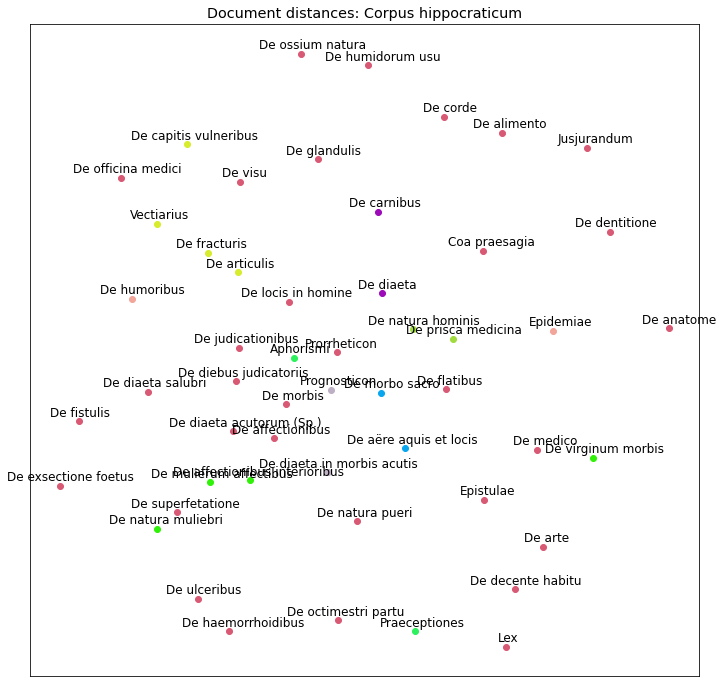

In [77]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams.update({'font.size': 12})

mds = MDS(n_components=2, random_state=1, dissimilarity='precomputed') # dissimilarity="precomputed",


fig, ax = plt.subplots()

# we need to transform the indovidual distances into a 2-dimensional space
# mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(c_hip_vec[2])
xs, ys = pos[:, 0], pos[:, 1]
# to have the plot big enough, we will modify default size of all generated plots
# (original is 6 to 4 inches)
#fig = plt.figure()
# now we can plot the distances transformed via the mds function as a scatter plot
for x, y, name, color in zip(xs, ys, c_hip_vec[2].columns, colors):
    ax.scatter(x, y, c=np.array([color]))
    x = x- (0.006 * len(name))
    ax.text(x, y+0.01, name)
ax.set_title("Document distances: Corpus hippocraticum")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)